# Jypter Notebook to reproduce the results in the report

### Getting the performance on the validation and test set

In [18]:
import numpy as np
import cv2 as cv
import yaml
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os
import torch
import matplotlib.pyplot as plt
from team_template.src.models import Unet2, Unet3, Ensemble
from competition_toolkit.eval_functions import iou, biou


The following code cell was taken from dataloader.py in the competition toolkit, partly because it had to be fitted so that it would work correctly for our purpose, but also to avoid any issues when reading files from a location.

In [19]:
def get_paths_from_folder(folder: str) -> list:
    allowed_filetypes = ["jpg", "jpeg", "png", "tif", "tiff"]

    paths = []

    for file in os.listdir(folder):
        filetype = file.split(".")[1]

        if filetype not in allowed_filetypes:
            continue

        path = os.path.join(folder, file)

        paths.append(path)

    return paths

def load_image(imagepath: str, size: tuple) -> torch.tensor:
    # imagepath = 'data\\validation\\images\\6259_564_0.tif'
    image = cv.imread(imagepath, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, size)

    image = torch.tensor(image.astype(np.uint8)) / 255
    image = torch.permute(image, (2, 0, 1))

    return image


def load_label(labelpath: str, size: tuple) -> torch.tensor:
    label = cv.imread(labelpath, cv.IMREAD_GRAYSCALE)
    label[label == 255] = 1
    label = cv.resize(label, size)

    label = torch.tensor(label.astype(np.uint8)).long()

    return label


class TestDataset(Dataset):
    def __init__(self,
                 opts: dict, imagepaths: list, labelpaths: list,
                 datatype: str = "test"):
        self.opts = opts
        self.imagepaths = imagepaths
        self.labelpaths = labelpaths

    def __len__(self):
        return len(self.imagepaths)

    def __getitem__(self, idx):
        imagefilepath = self.imagepaths[idx]
        labelfilepath = self.labelpaths[idx]

        assert imagefilepath.split("\\")[-1] == labelfilepath.split("\\")[
            -1], f"imagefilename and labelfilename does not match; {imagefilepath.split('/')[-1]} != {labelfilepath.split('/')[-1]}"

        image = load_image(imagefilepath, (self.opts["imagesize"], self.opts["imagesize"]))
        label = load_label(labelfilepath, (self.opts["imagesize"], self.opts["imagesize"]))
        filename = imagefilepath.split("\\")[-1]

        return image, label, filename


def create_dataloader(opts: dict, imagepaths: list, labelpaths: list, datatype: str = "test") -> DataLoader:
    dataset = TestDataset(opts, imagepaths, labelpaths, datatype)
    dataloader = DataLoader(dataset, batch_size=opts[f"task{opts['task']}"]["batchsize"],
                            shuffle=opts[f"task{opts['task']}"]["shuffle"])

    return dataloader


Load models

In [20]:
device = 'cuda'

model1 = Unet2()
model2 = Unet3()

if torch.cuda.is_available():
    model1.load_state_dict(torch.load("./team_template/src/runs/task_1/run_29_BCE_DICE_LOSS/best_task1_104.pt"))
    model2.load_state_dict(torch.load("./team_template/src/runs/task_1/run_30/best_task1_26.pt"))

else:
    model1.load_state_dict(torch.load("./team_template/src/runs/task_1/run_29_BCE_DICE_LOSS/best_task1_104.pt",  map_location=torch.device('cpu')))
    model2.load_state_dict(torch.load("./team_template/src/runs/task_1/run_30/best_task1_26.pt", map_location=torch.device('cpu')))
    device = 'cpu'

model1.eval()
model2.eval()

models_to_ensamble = [model1.to(device), model2.to(device)]
model = Ensemble(models_to_ensamble)

if torch.cuda.is_available():
    model.load_state_dict(torch.load("./team_template/src/runs/task_1/run_32/best_task1_2.pt"))

else:
    model.load_state_dict(torch.load("./team_template/src/runs/task_1/run_32/best_task1_2.pt", map_location=torch.device('cpu')))


In [21]:
runs = [
    {
        'run': 'run_30',
        'model': model2,
        'model_name': 'Simple U-Net (smaller)'
    },
    {
        'run': 'run_29_BCE_DICE_LOSS',
        'model': model1,
        'model_name': 'Simple U-Net (larger)'
    },
    {
        'run': 'run_32',
        'model': model,
        'model_name': 'Ensemble'
    }

]

The Following code cell is also taken from the competition code, model_task_1.py in the team_template.src folder, although it has been edited to serve our purpose.

In [22]:
for run_ in runs:
    run = run_['run']
    print(run_['model_name'])
    config = f'team_template/src/runs/task_1/{run}/opts.yaml'
    with open(config, "r") as f:
        opts = yaml.load(f, Loader=yaml.Loader)
    opts["device"] = device

    dataset = {'validation': 'data/validation/', 'test': 'sjyhne/mapai_evaluation_data/test/'}
    datatype = 'test'
    opts['task1']['batchsize'] = 1
    for key in dataset:

        print(key)
        predictions_path = f'team_template/src/runs/task_1/{run}/predictions/{key}'

        imagepaths = get_paths_from_folder(f'{dataset[key]}/images')#'sjyhne/mapai_evaluation_data/test/images')
        labelpaths = get_paths_from_folder(f'{dataset[key]}/masks')#'sjyhne/mapai_evaluation_data/test/masks')
        dataloader = create_dataloader(opts, imagepaths, labelpaths, datatype=datatype)
        print(dataloader)

        iou_scores = np.zeros((len(dataloader)))
        biou_scores = np.zeros((len(dataloader)))

        # %%
        for idx, (image, label, filename) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Inference",
                                                  leave=False):
            # Split filename and extension
            filename_base, file_extension = os.path.splitext(filename[0])

            # Send image and label to device (eg., cuda)
            image = image.to(device)
            label = label.to(device)

            # Perform model prediction
            cur_model = run_['model']
            prediction = cur_model(image)
            if isinstance(prediction, dict):
                prediction = prediction["out"]
            if opts["device"] == "cpu":
                prediction = (prediction > 0.5).float().squeeze(0).squeeze(0)  # for bcedice
            else:
                prediction = (prediction > 0.5).float().cpu().squeeze(0).squeeze(0)  # for bcedice


            if opts["device"] == "cpu":
                label = label.squeeze().detach().numpy()
            else:
                label = label.squeeze().cpu().detach().numpy()

            prediction = np.uint8(prediction)
            label = np.uint8(label)
            assert prediction.shape == label.shape, f"Prediction and label shape is not same, pls fix [{prediction.shape} - {label.shape}]"

            # Predict score
            iou_score = iou(prediction, label)
            biou_score = biou(label, prediction)

            iou_scores[idx] = np.round(iou_score, 6)
            biou_scores[idx] = np.round(biou_score, 6)

            prediction_visual = np.copy(prediction)

            for idx, value in enumerate(opts["classes"]):
                prediction_visual[prediction_visual == idx] = opts["class_to_color"][value]

            if opts["device"] == "cpu":
                image = image.squeeze().detach().numpy()[:3, :, :].transpose(1, 2, 0)
            else:
                image = image.squeeze().cpu().detach().numpy()[:3, :, :].transpose(1, 2, 0)
            if filename[0] == '6259_564_10.tif' and run_['model_name'] == 'Simple U-Net (larger)':
                example_image = image
                example_prediction_visual = prediction_visual
                example_label = label


        print("iou_score:", np.round(iou_scores.mean(), 5), "biou_score:", np.round(biou_scores.mean(), 5), "Score:",
              np.round((iou_scores.mean() + biou_scores.mean()) / 2, 5))

        print('')

Simple U-Net (smaller)
validation


iou_score: 0.84715 biou_score: 0.70936 Score: 0.77826

test


iou_score: 0.5982 biou_score: 0.38479 Score: 0.49149

Simple U-Net (larger)
validation


iou_score: 0.85733 biou_score: 0.76209 Score: 0.80971

test


iou_score: 0.55004 biou_score: 0.46514 Score: 0.50759

Ensemble
validation


iou_score: 0.87239 biou_score: 0.76461 Score: 0.8185

test


iou_score: 0.58223 biou_score: 0.44004 Score: 0.51113



### Draw Image

Code cell below is also reused from model_task_1.py, although slightly modified.

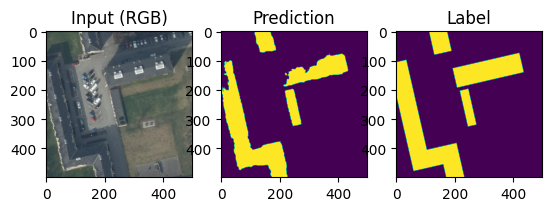

In [23]:

fig, ax = plt.subplots(1, 3)
columns = 3
rows = 1
ax[0].set_title("Input (RGB)")
ax[0].imshow(example_image)
ax[1].set_title("Prediction")
ax[1].imshow(example_prediction_visual)
ax[2].set_title("Label")
ax[2].imshow(example_label)

### Plotting Of Data

In [24]:
import matplotlib.pyplot as plt
import json

In [25]:
def plot_data(title, xs, ys, labels, labels2, x_axis_label, y_axis_label):
    for y_, label2 in zip(ys, labels2):
        plt.plot(xs, y_, label=f'{label2}')

    plt.ylabel(y_axis_label)
    plt.xlabel(x_axis_label)
    plt.legend()
    plt.title(title)
    plt.show()

In [26]:
def read_log_data(fps):
    all_runs_data = []
    for fp in fps:
        with open(f"{fp}", "r") as file:
            log_data = file.read()

        #turn it into valid json format
        log_data = log_data.replace("'", '"')
        log_data = log_data.replace("}\n{", '},\n{')
        log_data = f'[{log_data.strip()}]'

        json_data = json.loads(log_data)
        run_data = {}

        #Transpose data
        for entry in json_data:
            for key, value in entry.items():
                if key not in run_data:
                    run_data[key] = []
                run_data[key].append(value)

        all_runs_data.append(run_data)

    return all_runs_data

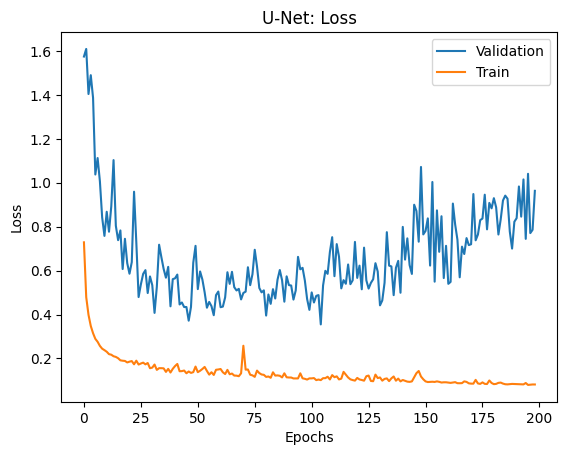

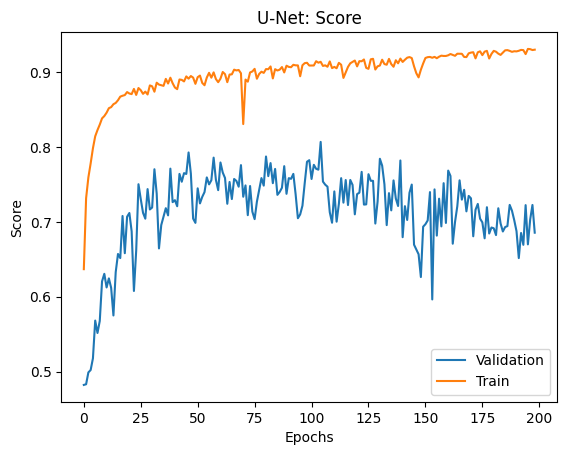

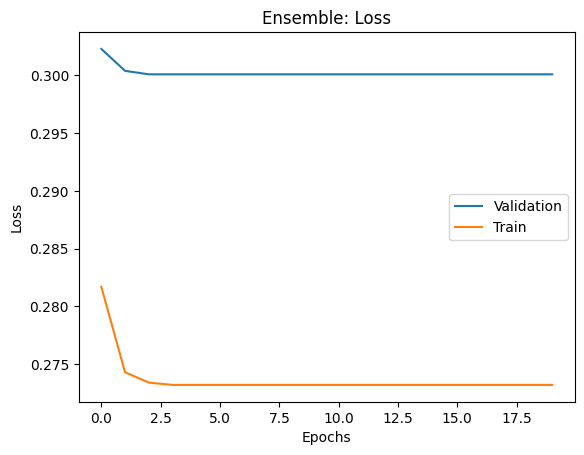

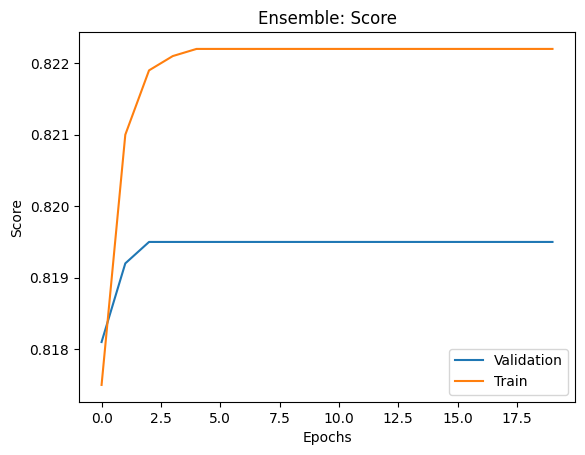

In [27]:
title = ['U-Net', 'Ensemble']
slice = [-1, 20]
labels = ['IoU', 'BIoU', 'Score']
labels2 = ['Validation', 'Train']
runs = ['run_29_BCE_DICE_LOSS', 'run_32']
fps = [f'team_template/src/runs/task_1/{run}/run.log' for run in runs]
all_data = read_log_data(fps)
key_pairs = {
    'testloss': ['trainloss', 'Loss'],
    'testscore': ['trainscore', 'Score'],
}
header = {'testloss': ['Loss', 'Loss'], 'testscore': ['Score', 'Score']}

for i, data in enumerate(all_data):
    for key, value in data.items():
        if key == 'epoch':
            continue
        if key in key_pairs:
            plot_data(f'{title[i]}: {key_pairs[key][1]}', data['epoch'][:slice[i]], [data[key][:slice[i]], data[key_pairs[key][0]][:slice[i]]], header[key], ['Validation', 'Train'],  'Epochs', key_pairs[key][1])#key_pairs[key][1], )
